# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [1]:
!pip install datasets torchmetrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy

from tqdm import tqdm

In [3]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
imdb_dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [ ]:
for sentence in tqdm(imdb_dataset):
  print(" "+ sentence +" ")

100%|██████████| 3/3 [00:00<00:00, 19418.07it/s]

 train 

 test 

 unsupervised 


In [6]:
# Split the train set into train and validation in 80-20 split. Use the labels
# to ensure that the ratio of the samples from each label is maintained
from sklearn.model_selection import train_test_split

# Extract reviews and corresponding labels
reviews = imdb_dataset["train"]["text"]
labels = imdb_dataset["train"]["label"]

test_reviews = imdb_dataset["test"]["text"]
test_labels = imdb_dataset["test"]["label"]


filtered_reviews = [review for review in reviews if 100 <= len(review.split()) <= 500]
filtered_labels = [label for review, label in zip(reviews, labels) if review in filtered_reviews]
train_reviews, val_reviews, train_labels, val_labels = train_test_split(filtered_reviews, filtered_labels, test_size=0.2, stratify=filtered_labels, random_state=SEED)

In [ ]:
print(len(reviews))
print(len(labels))
print(len(filtered_reviews))
print(len(filtered_labels))
print(len(train_reviews))
print(len(val_reviews))
print(len(train_labels))
print(len(val_labels))
print(len(test_reviews))
print(len(test_labels))

25000

25000

20056

20056

16044

4012

16044

4012

25000

25000


In [7]:
def clean(text, tokenizer):
  # Perform text preprocessing:

  # Remove numbers or replace them with "num" token
  text = re.sub(r'\d+', 'num', text)
  # Convert text to lowercase
  text = text.lower()
  # Tokenize the sentence into words
  words = tokenizer.tokenize(text)

  # You can use RegexpTokenizer from NLTK.

  # You will experiment with stemming/lemmatization down the line
  # so you can skip that for now

  return words

In [8]:
cleaned_text = clean("This IS 1 example sentence", RegexpTokenizer(r'\w+'))
print(cleaned_text)

['this', 'is', 'num', 'example', 'sentence']


In [9]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range

def get_word2idx(corpus,tokenizer, minlen=100, maxlen=500):
  word2idx = {}
  idx = 1
  for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):

    # drop sentences greater than maxlen or less than minlen
    if not minlen <= len(sentence.split()) <= maxlen:
      continue
    # process sentence
    sentence = clean(sentence, tokenizer)

    # for each word in sentence, check for entry in word2idx
    for word in sentence:
      if word not in word2idx:
          word2idx[word] = idx
          idx += 1

  return idx, word2idx

# corpus = ["This is an example sentence.", "Another sentence with different words."]
# tokenizer = RegexpTokenizer(r'\w+')
# max_index, word_to_idx = get_word2idx(corpus, tokenizer)
# print("Max index:", max_index)
# print("Word to index dictionary:", word_to_idx)

In [10]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word_to_idx, tokenizer, minlen=100, maxlen=500):
        self.count = 0
        self.minlen = minlen
        self.maxlen = maxlen

        input_data = []
        target_data = []

        for sentence, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Transforming input text"):
            if not self.minlen <= len(sentence.split()) <= self.maxlen:
                continue
            # Process sentence
            sentence = clean(sentence, tokenizer)
            unknown_index = 0
            # Replace words with their index
            indexed_sentence = [word_to_idx.get(word, unknown_index) for word in sentence]
            # Add sentence and label to input_data and target_data respectively
            input_data.append(torch.tensor(indexed_sentence))
            target_data.append(label)
            self.count += 1

        # Pad the sentences up to maxlen
        self.inputs = pad_sequence(input_data, batch_first=True)
        self.targets = torch.tensor(target_data)

    def __len__(self) -> int:
        return self.count

    def __getitem__(self, index: int):
        return self.inputs[index], self.targets[index]


# Example usage:
# Create dataset instance
# max_index, word_to_idx = get_word2idx(train_reviews, tokenizer=RegexpTokenizer(r'\w+'))
# print(max_index)
# print(word_to_idx)
# # Create dataset instance
# train_dataset = IMDBDataset(imdb_dataset, split="train", word_to_idx=word_to_idx, tokenizer=RegexpTokenizer(r'\w+'))
# # Access an item
# print(len(train_dataset[5]))
# sample_input, sample_target = train_dataset[1]
# print("Sample input:", len(sample_input))
# print("Sample target:", sample_target)

In [11]:
# create the train dataset using the word2idx dictionary built using the train set
max_index, word_to_idx = get_word2idx(train_reviews, tokenizer=RegexpTokenizer(r'\w+'))

train_ds = IMDBDataset(train_reviews, train_labels, word_to_idx, tokenizer=RegexpTokenizer(r'\w+'))
test_ds = IMDBDataset(test_reviews, test_labels, word_to_idx, tokenizer=RegexpTokenizer(r'\w+'))
val_ds = IMDBDataset(val_reviews, val_labels, word_to_idx, tokenizer=RegexpTokenizer(r'\w+'))

Transforming input text: 100%|██████████| 4012/4012 [00:01<00:00, 3227.41it/s]


In [ ]:
print(train_ds[1][0])
print(len(train_ds))
print(len(test_ds))

tensor([ 53, 122, 123,  27,  38,  96,  53, 124, 125,   8,  53, 126, 127, 128,

        102,  11,  78,  53, 129,  67,   6, 130, 131,  53, 102, 132, 133, 134,

         53,  54, 135, 136,   8,  53, 102, 137, 138, 139,  68,  38, 140,  11,

         53, 141, 142,  53, 122, 143,  27,  38,  53, 144, 142,   2, 145,  11,

        146,  11,  15,   2,  53, 147, 142,   8, 148,  53, 149, 150, 151, 152,

        153, 154,   4, 155, 114, 156, 157, 158,   6, 124, 159,   4,  53, 102,

         42, 160, 161,   4, 162, 163, 105, 164, 165, 166,  11, 167, 168, 169,

         21, 170, 171,   4, 172, 152, 153, 173, 174, 175,  53, 176,  27,  53,

        125, 177, 178,  27,  36, 179, 180, 181, 182, 183, 184, 185, 167, 186,

         11,  53,  40, 187,  27,  21, 188,  27, 189, 190, 191, 192, 193,   4,

        194, 195, 196, 197, 135,  40, 152, 198, 199,   8, 200, 201, 202, 203,

         96, 104,   8,  53, 204,  27, 205, 206,  11,  21, 188,  27, 207, 208,

        209, 210,  21, 211, 212, 213, 214,  68, 215,

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(16044, 4012, 20024)

In [12]:
# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

In [13]:
# create a model
class RNNModel(nn.Module):
  def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
    # call the init method of the parent
    super(RNNModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)


  def forward(self, X):
    embedded = self.embedding(X)
    output, h = self.rnn(embedded)
    output = h[-1]
    logits = self.fc(output)
    return logits

In [14]:
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2
vocab_size = max_index + 1
# create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)
print(optimizer)

RNNModel(
  (embedding): Embedding(58511, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [15]:
criterion = nn.CrossEntropyLoss()

# Create a model training loop
def train_model(model, train_dataloader, val_dataloader, epochs):

  train_losses = []
  val_losses = []
  val_accuracy = []

  best_val_loss = float('inf')
  best_model = None

  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for input_batch, output_batch in tqdm(train_dataloader, total = len(train_dataloader), desc = "Training"):
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)
        optimizer.zero_grad()
        output = model(input_batch)
        loss = criterion(output, output_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_train += output_batch.size(0)
        correct_train += (predicted == output_batch).sum().item()

    train_loss /= len(train_dataloader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)

    ## VALIDATION STEP
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Validation
    with torch.no_grad():
      for input_batch, output_batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation"):
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)
        output = model(input_batch)
        loss = criterion(output, output_batch)
        val_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_val += output_batch.size(0)
        correct_val += (predicted == output_batch).sum().item()

    val_loss /= len(val_dataloader)
    val_accuracy_value = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracy.append(val_accuracy_value)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy_value:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()

  return train_losses, val_losses, val_accuracy

In [16]:
# Create a model testing loop
def test_model(test_loader, model):
    model.eval()
    correct = 0
    test_loss = 0.0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_dataloader)
    test_accuracy = correct / total
    return test_accuracy

In [ ]:
# train the model
train_losses, val_losses, val_accuracy = train_model(model,train_dataloader,val_dataloader,epochs=5)

Training: 100%|██████████| 502/502 [00:07<00:00, 69.98it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 184.95it/s]


Epoch [1/5], Train Loss: 0.7012, Train Accuracy: 0.5009, Val Loss: 0.8627, Val Accuracy: 0.5062


Training: 100%|██████████| 502/502 [00:05<00:00, 91.02it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 179.32it/s]


Epoch [2/5], Train Loss: 0.7124, Train Accuracy: 0.5014, Val Loss: 0.6927, Val Accuracy: 0.5122


Training: 100%|██████████| 502/502 [00:07<00:00, 70.84it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 180.25it/s]


Epoch [3/5], Train Loss: 0.7025, Train Accuracy: 0.4998, Val Loss: 0.6986, Val Accuracy: 0.5127


Training: 100%|██████████| 502/502 [00:05<00:00, 91.31it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 179.63it/s]


Epoch [4/5], Train Loss: 0.7065, Train Accuracy: 0.4998, Val Loss: 0.7046, Val Accuracy: 0.5102


Training: 100%|██████████| 502/502 [00:05<00:00, 87.44it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 182.34it/s]

Epoch [5/5], Train Loss: 0.6998, Train Accuracy: 0.5052, Val Loss: 0.7061, Val Accuracy: 0.5132


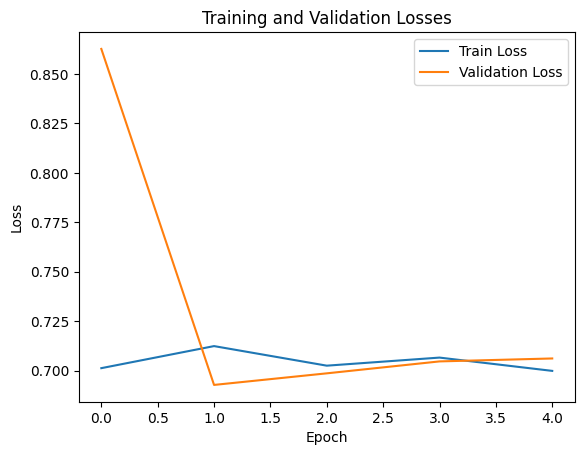

In [ ]:
# plot training and validation losses
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

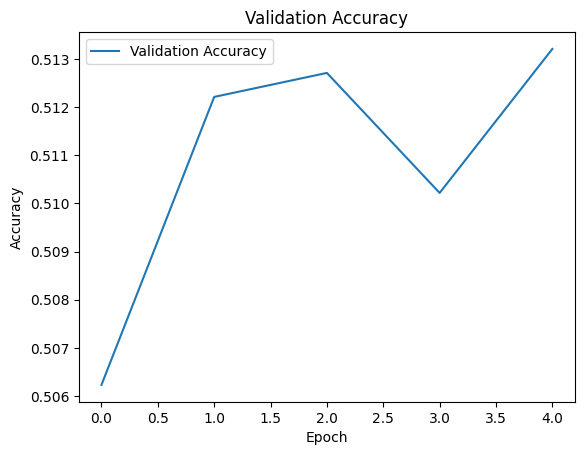

In [ ]:
# plot validation accuracy
def plot_accuracy(val_accuracy):
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(val_accuracy)

In [ ]:
# find the classification accuracy on test set
test_accuracy = test_model(test_dataloader, model)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.5082


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [ ]:
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

def clean1(text, tokenizer, lemmatizer, stop_words):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word_to_idx, tokenizer, minlen=100, maxlen=500):
        self.count = 0
        self.minlen = minlen
        self.maxlen = maxlen

        input_data = []
        target_data = []

        for sentence, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Transforming input text"):
            if not self.minlen <= len(sentence.split()) <= self.maxlen:
                continue
            sentence = clean1(sentence, tokenizer, lemmatizer, stop_words)
            unknown_index = 0
            indexed_sentence = [word_to_idx.get(word, unknown_index) for word in sentence]
            input_data.append(torch.tensor(indexed_sentence))
            target_data.append(label)
            self.count += 1

        # Pad the sentences up to maxlen
        self.inputs = pad_sequence(input_data, batch_first=True)
        self.targets = torch.tensor(target_data)

    def __len__(self) -> int:
        return self.count

    def __getitem__(self, index: int):
        return self.inputs[index], self.targets[index]


train_ds1 = IMDBDataset(train_reviews, train_labels, word_to_idx, tokenizer=RegexpTokenizer(r'\w+'))
test_ds1 = IMDBDataset(test_reviews, test_labels, word_to_idx, tokenizer=RegexpTokenizer(r'\w+'))
val_ds1 = IMDBDataset(val_reviews, val_labels, word_to_idx, tokenizer=RegexpTokenizer(r'\w+'))


[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Unzipping tokenizers/punkt.zip.

[nltk_data] Downloading package wordnet to /root/nltk_data...

[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Unzipping corpora/stopwords.zip.

Transforming input text: 100%|██████████| 16044/16044 [00:13<00:00, 1185.48it/s]

Transforming input text: 100%|██████████| 25000/25000 [00:12<00:00, 2073.25it/s]

Transforming input text: 100%|██████████| 4012/4012 [00:02<00:00, 1752.26it/s]


In [ ]:
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader1 = DataLoader(train_ds1, **params)
val_dataloader1 = DataLoader(val_ds1, **params)
test_dataloader1 = DataLoader(test_ds1, **params)

model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses1, val_losses1, val_accuracy1 = train_model(model,train_dataloader1,val_dataloader1,epochs=5)

Training: 100%|██████████| 502/502 [00:05<00:00, 90.56it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 216.46it/s]


Epoch [1/5], Train Loss: 0.7025, Train Accuracy: 0.5050, Val Loss: 0.7013, Val Accuracy: 0.4880


Training: 100%|██████████| 502/502 [00:04<00:00, 109.89it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 215.08it/s]


Epoch [2/5], Train Loss: 0.7010, Train Accuracy: 0.5007, Val Loss: 0.7223, Val Accuracy: 0.5120


Training: 100%|██████████| 502/502 [00:04<00:00, 106.16it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 145.32it/s]


Epoch [3/5], Train Loss: 0.6981, Train Accuracy: 0.5011, Val Loss: 0.6943, Val Accuracy: 0.4880


Training: 100%|██████████| 502/502 [00:04<00:00, 104.02it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 214.67it/s]


Epoch [4/5], Train Loss: 0.7011, Train Accuracy: 0.5022, Val Loss: 0.7028, Val Accuracy: 0.4880


Training: 100%|██████████| 502/502 [00:04<00:00, 109.28it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 162.45it/s]

Epoch [5/5], Train Loss: 0.6976, Train Accuracy: 0.4998, Val Loss: 0.6961, Val Accuracy: 0.4880


In [ ]:
# Evaluate model on test set
test_accuracy1 = test_model(test_dataloader1, model)
print(f'Test Accuracy: {test_accuracy1:.4f}')

Test Accuracy: 0.4910


#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [21]:
class RNNModel3(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_output, _ = self.rnn(embedded)
        # Take the mean output instead of the last output
        mean_output = torch.mean(rnn_output, dim=1)
        output = self.fc(mean_output)
        # Apply softmax activation for classification
        output = torch.softmax(output, dim=1)
        return output


model3 = RNNModel3(vocab_size, hidden_size, embedding_dim, num_classes).to(device)
train_losses, val_losses, val_accuracy = train_model(model3,train_dataloader,val_dataloader,epochs=10)
test_accuracy2 = test_model(test_dataloader, model)
print(f'Test Accuracy: {test_accuracy2:.4f}')

Validation: 100%|██████████| 126/126 [00:00<00:00, 188.70it/s]


Epoch [1/10], Train Loss: 0.6944, Train Accuracy: 0.4964, Val Loss: 0.6941, Val Accuracy: 0.4880


Validation: 100%|██████████| 126/126 [00:00<00:00, 197.70it/s]


Epoch [2/10], Train Loss: 0.6944, Train Accuracy: 0.4948, Val Loss: 0.6941, Val Accuracy: 0.4880


Validation: 100%|██████████| 126/126 [00:00<00:00, 187.51it/s]


Epoch [3/10], Train Loss: 0.6950, Train Accuracy: 0.4853, Val Loss: 0.6941, Val Accuracy: 0.4880


Validation: 100%|██████████| 126/126 [00:00<00:00, 188.96it/s]


Epoch [4/10], Train Loss: 0.6944, Train Accuracy: 0.4883, Val Loss: 0.6941, Val Accuracy: 0.4880


Validation: 100%|██████████| 126/126 [00:00<00:00, 184.53it/s]


Epoch [5/10], Train Loss: 0.6942, Train Accuracy: 0.4963, Val Loss: 0.6941, Val Accuracy: 0.4880


Validation: 100%|██████████| 126/126 [00:00<00:00, 187.43it/s]


Epoch [6/10], Train Loss: 0.6942, Train Accuracy: 0.4946, Val Loss: 0.6941, Val Accuracy: 0.4880


Validation: 100%|██████████| 126/126 [00:00<00:00, 197.69it/s]


Epoch [7/10], Train Loss: 0.6942, Train Accuracy: 0.4955, Val Loss: 0.6941, Val Accuracy: 0.4880


Validation: 100%|██████████| 126/126 [00:00<00:00, 190.00it/s]


Epoch [8/10], Train Loss: 0.6943, Train Accuracy: 0.4899, Val Loss: 0.6941, Val Accuracy: 0.4880


Validation: 100%|██████████| 126/126 [00:00<00:00, 192.00it/s]


Epoch [9/10], Train Loss: 0.6943, Train Accuracy: 0.4898, Val Loss: 0.6941, Val Accuracy: 0.4880


Validation: 100%|██████████| 126/126 [00:00<00:00, 180.13it/s]

Epoch [10/10], Train Loss: 0.6944, Train Accuracy: 0.4905, Val Loss: 0.6941, Val Accuracy: 0.4880


Test Accuracy: 0.5089


**Focus on Final Prediction:**

**Focus on Final Prediction:**
Here the model primarily focuses on the information encoded in the final hidden state. This approach is often suitable for tasks such as sentiment analysis.
However, it may lead to information loss.

**Reduced Computational Cost:**
Since only the last output is considered, the computational cost is reduced. This can lead to faster training.

**Taking the Mean of All Outputs:**

**Incorporating Global Information:**
Calculating the mean of all outputs in the RNN layer allows the model to incorporate information from every time step of the sequence into the final prediction. This approach is often suitable for tasks such as summarization or sequence-to-sequence tasks.

**Increased Computational Cost:**
Processing and aggregating all outputs to compute the mean incur a higher computational cost.This can result in longer training.

### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [ ]:
# Define hyperparameter configurations
hyperparameters = [
    {'embedding_dim': 128, 'hidden_size': 256, 'batch_size': 32},
    {'embedding_dim': 256, 'hidden_size': 512, 'batch_size': 64},
    {'embedding_dim': 64, 'hidden_size': 128, 'batch_size': 16},
    {'embedding_dim': 128, 'hidden_size': 512, 'batch_size': 128},
    {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 64}
]

results = []
for params in hyperparameters:
    model = RNNModel(vocab_size, params['hidden_size'], params['embedding_dim'], num_classes).to(device)

    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=params['batch_size'])

    train_losses, val_losses, val_accuracy = train_model(model, train_loader, val_loader,epochs=5)

    test_loader = DataLoader(test_ds, batch_size=params['batch_size'])
    test_accuracy = test_model(test_loader, model)

    results.append({
        'params': params,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
    })

Training: 100%|██████████| 502/502 [00:04<00:00, 120.30it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 317.16it/s]


Epoch [1/5], Train Loss: 0.6971, Train Accuracy: 0.5121, Val Loss: 0.6971, Val Accuracy: 0.5120


Training: 100%|██████████| 502/502 [00:04<00:00, 118.32it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 309.66it/s]


Epoch [2/5], Train Loss: 0.6971, Train Accuracy: 0.5121, Val Loss: 0.6971, Val Accuracy: 0.5120


Training: 100%|██████████| 502/502 [00:03<00:00, 128.88it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 261.54it/s]


Epoch [3/5], Train Loss: 0.6972, Train Accuracy: 0.5121, Val Loss: 0.6971, Val Accuracy: 0.5120


Training: 100%|██████████| 502/502 [00:03<00:00, 127.27it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 298.79it/s]


Epoch [4/5], Train Loss: 0.6972, Train Accuracy: 0.5121, Val Loss: 0.6971, Val Accuracy: 0.5120


Training: 100%|██████████| 502/502 [00:03<00:00, 131.28it/s]

Validation: 100%|██████████| 126/126 [00:00<00:00, 319.19it/s]


Epoch [5/5], Train Loss: 0.6971, Train Accuracy: 0.5121, Val Loss: 0.6971, Val Accuracy: 0.5120


Training: 100%|██████████| 251/251 [00:11<00:00, 22.52it/s]

Validation: 100%|██████████| 63/63 [00:01<00:00, 60.72it/s]


Epoch [1/5], Train Loss: 0.6931, Train Accuracy: 0.5121, Val Loss: 0.6931, Val Accuracy: 0.5120


Training: 100%|██████████| 251/251 [00:10<00:00, 24.33it/s]

Validation: 100%|██████████| 63/63 [00:01<00:00, 60.36it/s]


Epoch [2/5], Train Loss: 0.6931, Train Accuracy: 0.5121, Val Loss: 0.6931, Val Accuracy: 0.5120


Training: 100%|██████████| 251/251 [00:10<00:00, 24.11it/s]

Validation: 100%|██████████| 63/63 [00:01<00:00, 59.84it/s]


Epoch [3/5], Train Loss: 0.6931, Train Accuracy: 0.5121, Val Loss: 0.6931, Val Accuracy: 0.5120


Training: 100%|██████████| 251/251 [00:10<00:00, 24.10it/s]

Validation: 100%|██████████| 63/63 [00:01<00:00, 60.34it/s]


Epoch [4/5], Train Loss: 0.6931, Train Accuracy: 0.5121, Val Loss: 0.6931, Val Accuracy: 0.5120


Training: 100%|██████████| 251/251 [00:10<00:00, 24.03it/s]

Validation: 100%|██████████| 63/63 [00:01<00:00, 59.77it/s]


Epoch [5/5], Train Loss: 0.6931, Train Accuracy: 0.5121, Val Loss: 0.6931, Val Accuracy: 0.5120


Training: 100%|██████████| 1003/1003 [00:03<00:00, 260.25it/s]

Validation: 100%|██████████| 251/251 [00:00<00:00, 639.18it/s]


Epoch [1/5], Train Loss: 0.7272, Train Accuracy: 0.5121, Val Loss: 0.7270, Val Accuracy: 0.5122


Training: 100%|██████████| 1003/1003 [00:03<00:00, 257.39it/s]

Validation: 100%|██████████| 251/251 [00:00<00:00, 634.84it/s]


Epoch [2/5], Train Loss: 0.7272, Train Accuracy: 0.5121, Val Loss: 0.7270, Val Accuracy: 0.5122


Training: 100%|██████████| 1003/1003 [00:04<00:00, 220.96it/s]

Validation: 100%|██████████| 251/251 [00:00<00:00, 662.67it/s]


Epoch [3/5], Train Loss: 0.7271, Train Accuracy: 0.5121, Val Loss: 0.7270, Val Accuracy: 0.5122


Training: 100%|██████████| 1003/1003 [00:03<00:00, 263.79it/s]

Validation: 100%|██████████| 251/251 [00:00<00:00, 672.03it/s]


Epoch [4/5], Train Loss: 0.7272, Train Accuracy: 0.5121, Val Loss: 0.7270, Val Accuracy: 0.5122


Training: 100%|██████████| 1003/1003 [00:04<00:00, 246.15it/s]

Validation: 100%|██████████| 251/251 [00:00<00:00, 461.27it/s]


Epoch [5/5], Train Loss: 0.7272, Train Accuracy: 0.5121, Val Loss: 0.7270, Val Accuracy: 0.5122


Training: 100%|██████████| 126/126 [00:07<00:00, 17.02it/s]

Validation: 100%|██████████| 32/32 [00:00<00:00, 47.32it/s]


Epoch [1/5], Train Loss: 0.6963, Train Accuracy: 0.4880, Val Loss: 0.6963, Val Accuracy: 0.4880


Training: 100%|██████████| 126/126 [00:07<00:00, 16.90it/s]

Validation: 100%|██████████| 32/32 [00:00<00:00, 46.73it/s]


Epoch [2/5], Train Loss: 0.6963, Train Accuracy: 0.4880, Val Loss: 0.6963, Val Accuracy: 0.4880


Training: 100%|██████████| 126/126 [00:07<00:00, 16.70it/s]

Validation: 100%|██████████| 32/32 [00:00<00:00, 46.43it/s]


Epoch [3/5], Train Loss: 0.6964, Train Accuracy: 0.4880, Val Loss: 0.6963, Val Accuracy: 0.4880


Training: 100%|██████████| 126/126 [00:07<00:00, 16.94it/s]

Validation: 100%|██████████| 32/32 [00:00<00:00, 46.70it/s]


Epoch [4/5], Train Loss: 0.6962, Train Accuracy: 0.4880, Val Loss: 0.6963, Val Accuracy: 0.4880


Training: 100%|██████████| 126/126 [00:07<00:00, 16.80it/s]

Validation: 100%|██████████| 32/32 [00:00<00:00, 47.18it/s]


Epoch [5/5], Train Loss: 0.6963, Train Accuracy: 0.4880, Val Loss: 0.6963, Val Accuracy: 0.4880


Training: 100%|██████████| 251/251 [00:04<00:00, 60.72it/s]

Validation: 100%|██████████| 63/63 [00:00<00:00, 169.83it/s]


Epoch [1/5], Train Loss: 0.7088, Train Accuracy: 0.5121, Val Loss: 0.7088, Val Accuracy: 0.5120


Training: 100%|██████████| 251/251 [00:03<00:00, 63.09it/s]

Validation: 100%|██████████| 63/63 [00:00<00:00, 170.72it/s]


Epoch [2/5], Train Loss: 0.7088, Train Accuracy: 0.5121, Val Loss: 0.7088, Val Accuracy: 0.5120


Training: 100%|██████████| 251/251 [00:04<00:00, 62.16it/s]

Validation: 100%|██████████| 63/63 [00:00<00:00, 153.83it/s]


Epoch [3/5], Train Loss: 0.7087, Train Accuracy: 0.5121, Val Loss: 0.7088, Val Accuracy: 0.5120


Training: 100%|██████████| 251/251 [00:04<00:00, 61.99it/s]

Validation: 100%|██████████| 63/63 [00:00<00:00, 169.43it/s]


Epoch [4/5], Train Loss: 0.7087, Train Accuracy: 0.5121, Val Loss: 0.7088, Val Accuracy: 0.5120


Training: 100%|██████████| 251/251 [00:03<00:00, 62.96it/s]

Validation: 100%|██████████| 63/63 [00:00<00:00, 170.14it/s]


Epoch [5/5], Train Loss: 0.7087, Train Accuracy: 0.5121, Val Loss: 0.7088, Val Accuracy: 0.5120


### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes, dropout_rate=0.5, num_layers=5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)
        embedded = self.dropout(embedded)
        output, _ = self.lstm(embedded)
        output = output[:, -1, :]
        logits = self.fc(output)
        return logits

scheduler = StepLR(optimizer, step_size=1, gamma=0.95)

def train_LSTM_model(model, train_dataloader, val_dataloader, epochs):
    train_losses = []
    val_losses = []
    val_accuracy = []

    best_val_loss = float('inf')
    best_model = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for input_batch, output_batch in tqdm(train_dataloader, total=len(train_dataloader), desc="Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            optimizer.zero_grad()
            output = model(input_batch)
            loss = criterion(output, output_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_train += output_batch.size(0)
            correct_train += (predicted == output_batch).sum().item()

        train_loss /= len(train_dataloader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for input_batch, output_batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)
                output = model(input_batch)
                loss = criterion(output, output_batch)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total_val += output_batch.size(0)
                correct_val += (predicted == output_batch).sum().item()

        scheduler.step()
        val_loss /= len(val_dataloader)
        val_accuracy_value = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracy.append(val_accuracy_value)

        print(f'Epoch [{epoch + 1}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy_value:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    return train_losses, val_losses, val_accuracy

def test_LSTM_model(test_dataloader, model):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_dataloader, total=len(test_dataloader), desc="Testing"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            output = model(input_batch)
            loss = criterion(output, output_batch)
            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += output_batch.size(0)
            correct += (predicted == output_batch).sum().item()

    test_loss /= len(test_dataloader)
    test_accuracy = correct / total

    print(f'Test Accuracy for LSTM: {test_accuracy:.4f}')

    return test_accuracy

In [ ]:
best_embedding_dim = 64
best_hidden_size = 128
best_batch_size = 16

train_loader = DataLoader(train_ds, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=best_batch_size)
test_loader = DataLoader(test_ds, batch_size=best_batch_size)

LSTM_model = LSTMModel(vocab_size, best_hidden_size, best_embedding_dim, num_classes)
LSTM_model.to(device)

optimizer = torch.optim.Adam(LSTM_model.parameters())
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, val_accuracy = train_LSTM_model(LSTM_model, train_loader, val_loader, epochs=5)

test_accuracy = test_LSTM_model(test_loader, LSTM_model)

Training: 100%|██████████| 251/251 [00:10<00:00, 23.20it/s]

Validation: 100%|██████████| 64/64 [00:01<00:00, 53.16it/s]


Epoch 1, Train Loss: 0.0227, Val Loss: 0.4400, Val Accuracy: 86.91%


Training: 100%|██████████| 251/251 [00:11<00:00, 22.17it/s]

Validation: 100%|██████████| 64/64 [00:01<00:00, 52.27it/s]


Epoch 2, Train Loss: 0.0105, Val Loss: 0.6532, Val Accuracy: 87.09%


Training: 100%|██████████| 251/251 [00:10<00:00, 24.11it/s]

Validation: 100%|██████████| 64/64 [00:01<00:00, 52.71it/s]


Epoch 3, Train Loss: 0.0028, Val Loss: 0.6732, Val Accuracy: 87.34%


Training: 100%|██████████| 251/251 [00:10<00:00, 23.67it/s]

Validation: 100%|██████████| 64/64 [00:01<00:00, 51.74it/s]


Epoch 4, Train Loss: 0.0062, Val Loss: 0.5924, Val Accuracy: 87.06%


Training: 100%|██████████| 251/251 [00:10<00:00, 24.27it/s]

Validation: 100%|██████████| 64/64 [00:01<00:00, 52.37it/s]

Epoch 5, Train Loss: 0.0077, Val Loss: 0.7092, Val Accuracy: 86.67%


 Test Accuracy for LSTM: 85.67%


Replacing the Recurrent Neural Network (RNN) layer with the Long Short-Term Memory (LSTM) layer using nn.LSTM resulted in following changes.

**Improved Long-Term Dependencies Handling:**
LSTMs are specifically designed to capture long-term dependencies more effectively whereas RNNs struggle to retain information over long sequences due to gradient vanishing or exploding.

**Better Handling of Short-Term Dependencies:**
LSTMs adaptively update and forget information based on the current context, allowing them to capture most important features and dependencies within the data.

**Reduced Vanishing Gradient Issues:**
RNNs often suffer from the vanishing gradient problem, where gradients diminish exponentially over time, making it challenging for the network to learn from distant past information.
LSTMs overcomes this issue by having gating mechanisms (e.g., input, forget, and output gates) that control the flow of information, allowing them to preserve and propagate gradients more effectively through time. As a result, LSTMs does not suffer from gradient vanishing.

**Increased Model Complexity:**
LSTMs introduce additional parameters compared to standard RNNs due to their more complex architecture involving multiple gating units.
This increases complexity but may also improve the model's ability to capture long-term dependencies.It also has a higher computational cost.